# Stock Trading Strategy using Monte Carlo Simulation
**Author**: 

1. Moch Nabil Farras Dhiya (10120034)
2. Felix Fernando (10120082)

**Institution**: Bandung Institute of Technology


---

**About**: -

# Import Modules

In [1]:
# Extract stock market data
import yfinance as yf

# Importing and transforming file
import pandas as pd

# Data manipulation
import numpy as np
import datetime as dt # Datetime manipulation

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Ignore warnings
import warnings

In [2]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Fetch Stock Data

In [3]:
def fetch_data(stock, start_date, end_date):
    data = yf.download(stock, 
                       start = start_date, 
                       end = end_date, 
                       progress = False)

    data = data.reset_index()
    return data

In [4]:
# Start and End Date
start_date = '2021-01-01'
# end_date = '2023-02-28'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

In [5]:
stock = fetch_data(stock = 'BBCA.JK',
                   start_date = start_date, 
                   end_date = end_date)
stock

c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\yfinance\utils.py:703: UserWarning: Pandas requires version '2022.1' or newer of 'tzdata' (version '2021.1' currently installed).
  md[k] = _pd.to_datetime(md[k], unit='s', utc=True).tz_convert(tz)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,6800.0,6855.0,6720.0,6835.0,6590.835449,47937000
1,2021-01-05,6860.0,7090.0,6850.0,7090.0,6836.726074,104831000
2,2021-01-06,7050.0,7075.0,6880.0,6945.0,6696.906250,89753500
3,2021-01-07,7000.0,7050.0,6910.0,6965.0,6716.190918,71360000
4,2021-01-08,7035.0,7080.0,6975.0,7050.0,6798.154297,75033500
...,...,...,...,...,...,...,...
538,2023-03-07,8350.0,8475.0,8350.0,8425.0,8425.000000,106115600
539,2023-03-08,8400.0,8575.0,8400.0,8575.0,8575.000000,79350900
540,2023-03-09,8650.0,8650.0,8550.0,8575.0,8575.000000,54201400
541,2023-03-10,8500.0,8550.0,8450.0,8450.0,8450.000000,59580100


# Data Manipulation

We will do 3 things in order:
1. Make sure the column type is of datetime and float type
2. Drop null and negative values
3. Expand the dataset so it contains the weekend, then interpolate the values

In [6]:
def check_columns(data):
    for col in data.columns:
        if col == 'Date':
            if data[col].dtype == 'str':
                data[col] =  pd.to_datetime(data[col]).date()

        else:
            data[col] = data[col].astype('float64')

    return data

In [7]:
def check_values(data):
    cols = [col for col in data.columns if data[col].dtype == 'float64']

    # Null values
    data = data.dropna(subset = cols)

    # Negative values
    data = data[(data[cols] > 0).all(1)].reset_index(drop = True)

    return data

In [8]:
def expand_data(data, start_date, end_date):
    # Create temporary dataframe
    temp = pd.DataFrame()
    temp['Date'] = pd.date_range(start = start_date, 
                                 end = end_date)

    # Merge the data
    res = pd.merge(temp, data, how = 'left', on = 'Date')
    
    # Interpolate the missing values
    # IDR/USD dataset
    a = res.rolling(3).mean()
    b = res.iloc[::-1].rolling(3).mean()

    c = a.fillna(b).fillna(res).interpolate(method = 'nearest').ffill().bfill()

    res = res.fillna(c)

    return res

In [9]:
def final_data(data, start_date, end_date, criteria):
    # Check columns type
    data = check_columns(data = data)

    # Check null and negative values
    data = check_values(data = data)

    # Expand and interpolate
    data = expand_data(data = data, start_date = start_date, end_date = end_date)

    data = data.set_index('Date')
    
    return data[[criteria]]

In [10]:
stock = final_data(data = stock, start_date = start_date, end_date = end_date, criteria = 'Adj Close')
stock

C:\Users\acer\AppData\Local\Temp/ipykernel_12200/13038183.py:12: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  a = res.rolling(3).mean()
C:\Users\acer\AppData\Local\Temp/ipykernel_12200/13038183.py:13: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  b = res.iloc[::-1].rolling(3).mean()


,Adj Close
Date,
2021-01-01,6708.155924
2021-01-02,6708.155924
2021-01-03,6708.155924
2021-01-04,6590.835449
2021-01-05,6836.726074
...,...
2023-03-10,8450.000000
2023-03-11,8533.333333
2023-03-12,8550.000000


# Monte Carlo

In [11]:
def get_return(data):
    data['Daily Return'] = (data.iloc[:, 0] - data.iloc[:, 0].shift(1)) / data.iloc[:, 0].shift(1)
    # data['Daily Return'] = np.log(data.iloc[:, 0] / data.iloc[:, 0].shift(1))
    data = data.dropna()

    sns.displot(data['Daily Return'].dropna(), 
                bins = 50,
                color = 'blue', 
                kde = True)
    plt.title('Daily return distribution')
    plt.show()

    return data

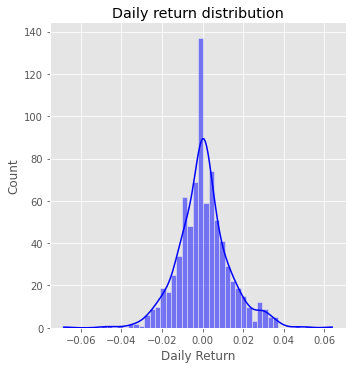

,Adj Close,Daily Return
Date,,
2021-01-02,6708.155924,0.000000
2021-01-03,6708.155924,0.000000
2021-01-04,6590.835449,-0.017489
2021-01-05,6836.726074,0.037308
2021-01-06,6696.906250,-0.020451
...,...,...
2023-03-10,8450.000000,-0.014577
2023-03-11,8533.333333,0.009862
2023-03-12,8550.000000,0.001953


In [12]:
stock = get_return(stock)
stock

In [13]:
# stock['Adj Close'].plot(legend = True, figsize = (15, 6))

In [14]:
n_sim = 5000
days = 30

In [15]:
def simulation(data, days, n_sim):   
    start_price = data.iloc[-1, 0]
    sim = np.zeros(n_sim)
    table = np.zeros((n_sim, days))

    delta = 1 / days
    mu = data['Daily Return'].mean()
    sigma = data['Daily Return'].std()
    def monte_carlo(start_price, days, mu = mu, sigma = sigma):
        price = np.zeros(days)
        price[0] = start_price
        
        shock = np.zeros(days)
        drift = np.zeros(days)
        
        for x in range(1, days):
            shock[x] = np.random.normal(loc = mu * delta, scale = sigma * np.sqrt(delta))
            drift[x] = mu * delta
            
            price[x] = price[x - 1] + (price[x - 1] * (drift[x] + shock[x]))
            
            # shock[x] = sigma * np.random.random()
            # drift[x] = mu - 1/2 * sigma ** 2
            # price[x] = price[x - 1] * np.exp(shock[x] + drift[x])
            
        return price

    # plt.figure(figsize = (15, 8))
    for i in range(n_sim):
        result = monte_carlo(start_price, days)
        table[i] = result
        sim[i] = result[days - 1]
    #     plt.plot(result)
        
    # plt.xlabel('Days')
    # plt.ylabel('Price')
    # plt.title('Monte Carlo Analysis')

    return table

In [16]:
price = simulation(data = stock, days = days, n_sim = n_sim)

In [17]:
def trading_algo(mrx):
    '''
    0: Hold
    1: Sell
    2: Buy
    '''
    res = np.zeros((mrx.shape[0], mrx.shape[1]))
    n_sim = mrx.shape[0]

    for i in range(n_sim):
        j = 1
        while j != mrx.shape[1] - 1:
            start = j
            cond = True

            # Check increasing
            if mrx[i, j] > mrx[i, j - 1]:
                while cond:

                    # Still increasing and not at the end
                    if (mrx[i, j] > mrx[i, j - 1]) & (j != mrx.shape[1] - 1):
                        j = j + 1

                    # At the end or price dropped
                    else:
                        # Still increasing at the end, sell
                        if mrx[i, j] > mrx[i, j - 1]:
                            res[i, j] = 1
                            res[i, start: j] = 0
                            cond = False

                        # Price dropped, sell at prev price
                        else:
                            res[i, j - 1] = 1
                            res[i, start: j - 1] = 0
                            cond = False

            # Check decreasing
            else:
                while cond:
                    
                    # Still decreasing and not at the end
                    if (mrx[i, j] < mrx[i, j - 1]) & (j != mrx.shape[1] - 1):
                        j = j + 1

                    # At the end or price increased
                    else:
                        # Still decreasing at the end, buy
                        if mrx[i, j] < mrx[i, j - 1]:
                            res[i, j] = 2
                            res[i, start: j] = 0
                            cond = False

                        # Price increased, buy at prev price
                        else:
                            res[i, j - 1] = 2
                            res[i, start: j - 1] = 0
                            cond = False

    
    return res

In [18]:
decisions = trading_algo(mrx = price)
decisions

array([[0., 1., 2., ..., 0., 0., 1.],
       [0., 1., 2., ..., 2., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 2.],
       [0., 1., 0., ..., 1., 0., 2.],
       [0., 1., 2., ..., 0., 1., 0.]])

In [19]:
# def trading_sim(price, decision, money):
#     '''
#     0: Hold
#     1: Sell
#     2: Buy
#     '''
#     res = np.zeros(price.shape[0])
#     n_sim = price.shape[0]
#     days = price.shape[1]

#     for i in range(n_sim):
#         # Initial stock at hand
#         stock = money / price[i, 0]
        
#         for j in range(days):
#             # Hold
#             if decision['DECISION'].iloc[j] == 0:
#                 pass

#             # Sell
#             elif decision['DECISION'].iloc[j] == 1:
#                 # Proportion of sell decision at given day
#                 arr = price[i, :]
#                 factor = (arr == 1).sum()

#                 curr_price = price[i, j]
#                 money = money + factor * stock * curr_price
#                 stock = (1 - factor) * stock

#             # Buy
#             else:
#                 # Proportion of buy decision at given day
#                 arr = price[i, :]
#                 factor = (arr == 2).sum()

#                 curr_price = price[i, j]
#                 money = (1 - factor) * money
#                 stock = stock + factor * money / curr_price

#         # Final day result
#         res[i] = money + stock * price[i, -1]

#     pct_return = 100 * (res - money) / money
    
#     return pct_return

In [20]:
def trading_sim(price, decision, money):
    
    '''
    0: Hold
    1: Sell
    2: Buy
    '''
    res = np.zeros(price.shape[0])
    n_sim = price.shape[0]
    days = price.shape[1]
    result_df = pd.DataFrame(columns = ['SIMULATION', 'PROFIT/LOSS', 'FINAL_BALANCE', 'STARTING_BALANCE'], 
                             index = [i for i in range(n_sim)])

    for i in range(n_sim):
        # Initial stock at hand
        stock = 0
        curr_money = money
        
        for j in range(days):
            # Hold
            if decision['DECISION'].iloc[j] == 0:
                pass

            # Sell
            elif decision['DECISION'].iloc[j] == 1:
                # Proportion of sell decision at given day
                factor = decision['SELL_CONF'].iloc[j] / (decision['SELL_CONF'].iloc[j] + decision['BUY_CONF'].iloc[j])
                curr_price = price[i, j]
                curr_money += stock * factor * curr_price
                stock -= stock * factor
            # Buy
            else:
                # Proportion of buy decision at given day
                factor = decision['BUY_CONF'].iloc[j] / (decision['SELL_CONF'].iloc[j] + decision['BUY_CONF'].iloc[j])
                curr_price = price[i, j]
                stock += factor * curr_money / curr_price
                curr_money -= factor * curr_money 

        # Final day result
        res[i] = curr_money + stock * price[i, -1]
        
        result_df['SIMULATION'].iloc[i] = i + 1
        result_df['FINAL_BALANCE'].iloc[i] = curr_money + stock * price[i, -1]
        result_df['STARTING_BALANCE'].iloc[i] = money
        
    pct_return = 100 * (res - money) / money
    result_df['PROFIT/LOSS'] = pct_return
    
    return result_df

In [21]:
def generate_decision_sequence(data, n_sim, days): 
    decision_df = pd.DataFrame(columns = ['DAY', 'DECISION', 'HOLD_CONF', 'BUY_CONF', 'SELL_CONF'], index = [i for i in range(days)])

    for i in range(days): 
        decision_df['DAY'].iloc[i] = i + 1
        buy = 0
        sell = 0
        hold = 0 

        for j in range(n_sim): 
            if data[j, i] == 0:
                hold += 1
            elif data[j, i] == 1:
                sell += 1
            else: 
                buy += 1

        if max(buy, sell, hold) == hold and (hold / n_sim) > 0.75:
            decision_df['DECISION'].iloc[i] = 0 
        elif max(buy, sell) == sell: 
            decision_df['DECISION'].iloc[i] = 1
        else:  
            decision_df['DECISION'].iloc[i] = 2

        decision_df['HOLD_CONF'].iloc[i] = hold / n_sim
        decision_df['BUY_CONF'].iloc[i] = buy / n_sim        
        decision_df['SELL_CONF'].iloc[i] = sell / n_sim        

    return decision_df

In [22]:
decision_sequence = generate_decision_sequence(decisions, n_sim, days)
decision_sequence

,DAY,DECISION,HOLD_CONF,BUY_CONF,SELL_CONF
0,1,0,1.0,0.0,0.0
1,2,1,0.5012,0.2462,0.2526
2,3,1,0.4964,0.2476,0.256
3,4,2,0.5098,0.2546,0.2356
4,5,1,0.4884,0.2536,0.258
5,6,1,0.4922,0.2514,0.2564
6,7,2,0.4914,0.2568,0.2518
7,8,2,0.4996,0.2512,0.2492
8,9,1,0.5042,0.244,0.2518
9,10,2,0.5148,0.248,0.2372


In [23]:
money = 1e8
final_sim = trading_sim(price = price, decision = decision_sequence, money = money)
final_sim

,SIMULATION,PROFIT/LOSS,FINAL_BALANCE,STARTING_BALANCE
0,1,0.536994,100536993.733169,100000000.0
1,2,0.791185,100791185.134919,100000000.0
2,3,-0.583009,99416991.232793,100000000.0
3,4,-0.032267,99967733.039223,100000000.0
4,5,-1.169180,98830820.06404,100000000.0
...,...,...,...,...
4995,4996,0.758431,100758430.887701,100000000.0
4996,4997,-1.456445,98543555.294951,100000000.0
4997,4998,0.292243,100292242.600506,100000000.0
4998,4999,0.030061,100030060.583628,100000000.0


In [30]:
print('Winning Percentage:', len(final_sim.loc[final_sim['PROFIT/LOSS'] >= 0]) / len(final_sim) * 100)
print('Max Return:', np.max(final_sim['PROFIT/LOSS']))
print('Min Return:', np.min(final_sim['PROFIT/LOSS']))

Winning Percentage: 52.6
Max Return: 2.479696241060838
Min Return: -2.146929045732826


In [31]:
np.argmax(final_sim['PROFIT/LOSS'])

3895

In [25]:
def validate_decision(data, days, decision, money, n_sim, n_valid):
    df = pd.DataFrame(columns = ['SIMULATION', 'WINNING_PERC', 'MAX_RETURN', 'MIN_RETURN'],
                      index=[i for i in range(n_valid)])
    for i in range(n_valid):
        validate = simulation(data = data, days = days, n_sim = n_sim)
        validate_sim = trading_sim(price = validate, decision = decision, money = money)

        winning = len(validate_sim.loc[validate_sim['PROFIT/LOSS'] >= 0]) / len(validate_sim) * 100
        max_return = np.max(validate_sim['PROFIT/LOSS'])
        min_return = np.min(validate_sim['PROFIT/LOSS'])

        df['SIMULATION'].iloc[i] = i + 1
        df['WINNING_PERC'].iloc[i] = winning
        df['MAX_RETURN'].iloc[i] = max_return
        df['MIN_RETURN'].iloc[i] = min_return

    return df

In [26]:
validate_sim = validate_decision(data = stock, days = days, n_sim = n_sim, n_valid = 10)
validate_sim

TypeError: validate_decision() missing 2 required positional arguments: 'decision' and 'money'